In [ ]:
# an example of transfer learning with VGG deep neural network 
# applied to 10 classes of fruits, the code is based on 
# https://github.com/lazyprogrammer/machine_learning_examples/blob/master/cnn_class2/use_pretrained_weights_vgg.py
# using Kaggle data set Fruits 360:
# https://www.kaggle.com/moltean/fruits

In [1]:
from __future__ import print_function, division
from builtins import range, input

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = [100, 100]

epochs = 5
batch_size = 32

train_path = 'data/fruits-360/Training'
valid_path = 'data/fruits-360/Validation'

image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# getting number of classes
folders = glob(train_path + '/*')

data/fruits-360/Training\Grape Pink\14_100.jpg


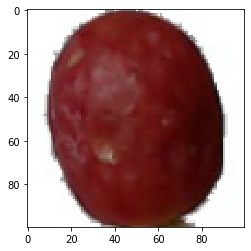

In [3]:
fr=np.random.choice(image_files)
print(fr)
plt.imshow(image.load_img(fr))
plt.show()

In [4]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False);

In [5]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [6]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [7]:
# create a model
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [8]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
);

In [9]:
# create an instance of ImageDataGenerator to increase number of samples
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [10]:
# test generator to see how it works 
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 1689 images belonging to 10 classes.
{'Apple Pink Lady': 0, 'Apricot': 1, 'Avocado': 2, 'Cherry Rainier': 3, 'Clementine': 4, 'Cocos': 5, 'Grapefruit Pink': 6, 'Kaki': 7, 'Kiwi': 8, 'Lemon': 9}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -81.763374 max: 151.061


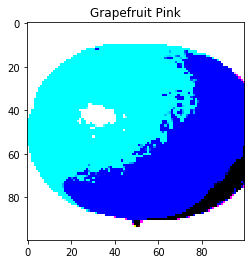

In [11]:
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [12]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 5033 images belonging to 10 classes.
Found 1689 images belonging to 10 classes.


In [13]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/5
157/157 [==============================] - 503s 3s/step - loss: 4.0667 - acc: 0.7299 - val_loss: 4.7847 - val_acc: 0.6983
Epoch 2/5
157/157 [==============================] - 510s 3s/step - loss: 3.1680 - acc: 0.8000 - val_loss: 4.6823 - val_acc: 0.7085
Epoch 3/5
157/157 [==============================] - 474s 3s/step - loss: 3.1477 - acc: 0.8037 - val_loss: 4.8140 - val_acc: 0.6940
Epoch 4/5
157/157 [==============================] - 467s 3s/step - loss: 3.1691 - acc: 0.8031 - val_loss: 4.7579 - val_acc: 0.7043
Epoch 5/5
157/157 [==============================] - 461s 3s/step - loss: 3.1349 - acc: 0.8053 - val_loss: 4.7232 - val_acc: 0.7061


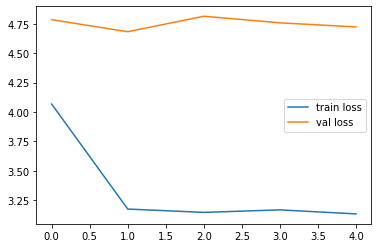

In [14]:
# plot losses
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

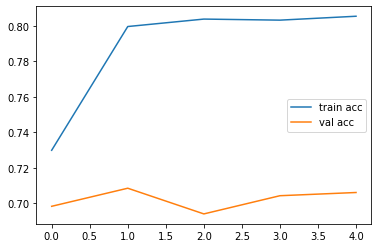

In [15]:
# plot accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [16]:
# function for building confusion matrix since the data was altered 
# by generator and need to be in the same order for both predictions and targets

def get_confusion_matrix(data_path, N):  
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [45]:
cm = get_confusion_matrix(train_path, len(image_files))
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))

Generating confusion matrix 5033
Found 5033 images belonging to 10 classes.
50
Generating confusion matrix 1689
Found 1689 images belonging to 10 classes.


In [57]:
# from https://github.com/lazyprogrammer/machine_learning_examples/blob/master/cnn_class2/util.py
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[456   0   0   0   0   0   0   0   0   0]
 [351   0   0   0   0   1  61  42   0  37]
 [  0   0 427   0   0   0   0   0   0   0]
 [  0   0   0 738   0   0   0   0   0   0]
 [ 15   0   0   0   0   0   0 475   0   0]
 [  0   0   0   0   0 490   0   0   0   0]
 [  0   0   0   0   0   0 492   0   0   0]
 [  0   0   0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   1   0   0 465   0]
 [  0   0   0   0   0   0   0   0   0 492]]


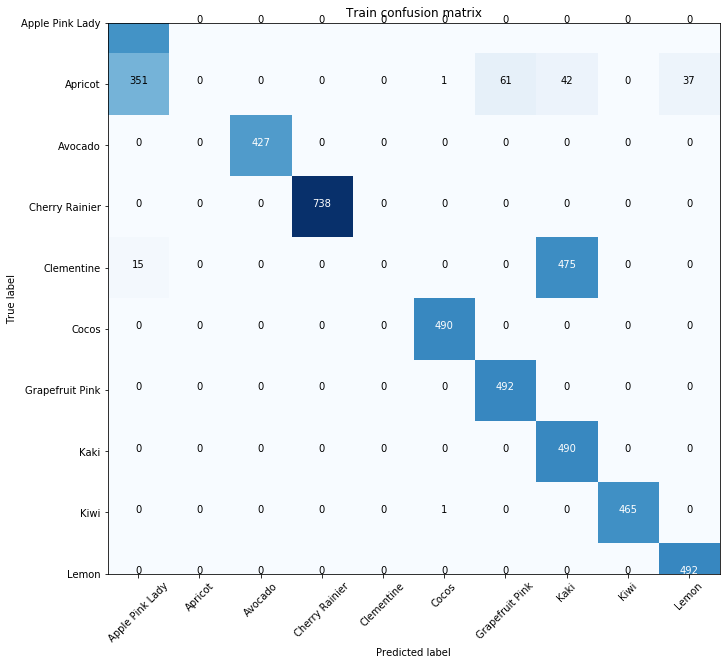

In [58]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix');

Confusion matrix, without normalization
[[152   0   0   0   0   0   0   0   0   0]
 [ 80   0   0   0   0   0  19  34   0  31]
 [  0   0 143   0   0   0   0   0   0   0]
 [  0   0   0 243   0   0   0   1   0   2]
 [  3   0   0   0   0   0   0 163   0   0]
 [  0   0   0   0   0 165   0   0   1   0]
 [  3   0   0   0   0   0   0 162   0   1]
 [  0   0   0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0   0   0 156   0]
 [  0   0   0   0   0   0   0   0   0 164]]


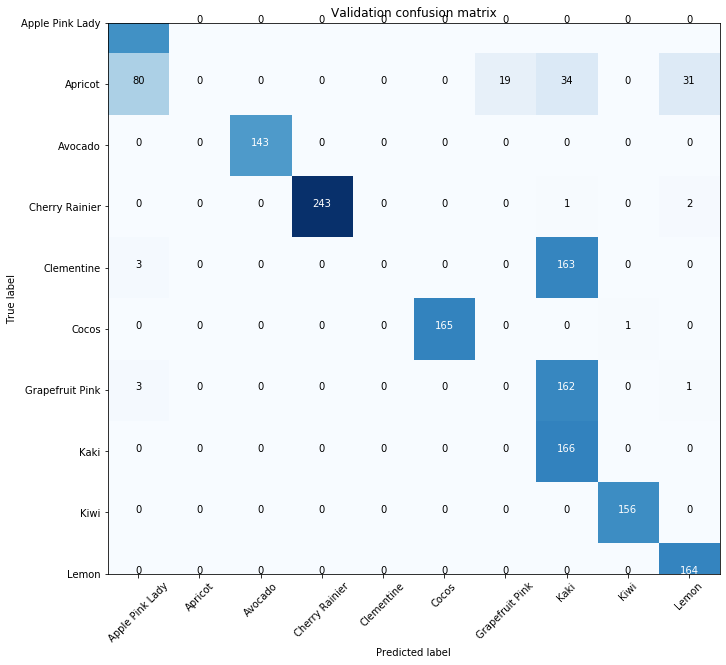

In [59]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')